In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt



from helpers import get_entry_points
from helpers import get_peaks
from helpers import get_strokes
from helpers import get_exit_and_air_points
from helpers import indicators_calculator
from helpers import strokes_indicators

plt.style.use(['science', 'notebook', 'grid'])
# plt.rcParams.update({
#     "figure.facecolor":  (0.0, 0.0, 0.0, 0.0),  # red   with alpha = 30%
#     "axes.facecolor":    (0.0, 0.0, 0.0, 0.0),  # green with alpha = 50%
#     "savefig.facecolor": (0.0, 0.0, 0.0, 0.0),  # blue  with alpha = 20%
# })
plt.rcParams['axes.facecolor'] = 'white'

# Divisao de um Stroke

''Canoe paddle strokes are the means by which a paddle (or paddles) is used to move a canoe through the water.''
<p>Para este estudo é importante dividir a remada nas suas varias compomentes ou fases.</p>

<p>Da observação do movimento do sistema barco - pagaia - atleta, podemos divir as varias fases conforme a imagem a baixo:</p>

![Stroke Fases](images/Observational-model-for-kayak-analysis-including-two-levels-of-analysis-phases-and.png)

<p>Observational model for kayak analysis including two levels of analysis: phases and sub-phases. The phase defining positions are catch (1), immersion (2), extraction (3), and release (4). R, right side; L, left side. [source](https://www.researchgate.net/figure/Observational-model-for-kayak-analysis-including-two-levels-of-analysis-phases-and_fig4_233972565).</p>

In [3]:
raw_data = pd.read_csv("data/serie1.csv", names='gx,gy,gz,ax,ay,az,roll,pitch,yaw,time_stamp,VideoRecord,DataRecord'.split(
    ','))

In [4]:
raw_data['time'] = pd.to_datetime(raw_data.time_stamp).diff().fillna(pd.Timedelta(0)).dt.total_seconds().cumsum()

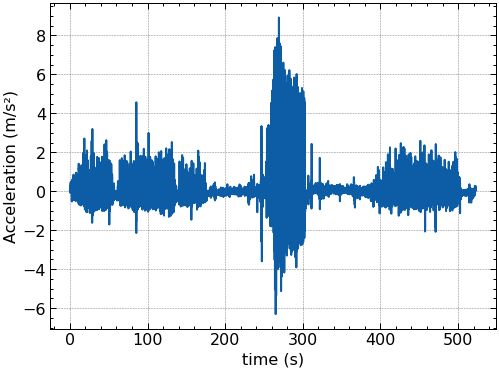

In [5]:
plt.figure()
plt.plot(raw_data['time'], raw_data.ax, label="XX Acceleration")
plt.xlabel('time (s)')
plt.ylabel(r'Acceleration (m/s²)')
plt.show()

In [6]:
def select_data_intervale(data, start, end):
    mask = (data.time >= start) & (data.time <= end)
    return data[mask].reset_index(drop=True).copy()

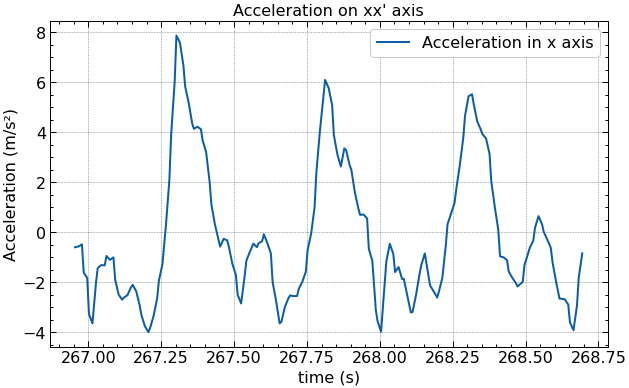

In [7]:
data = select_data_intervale(raw_data, 266.95, 268.7)
plt.figure(figsize=(10, 6))

plt.plot(data['time'], data.ax, label="Acceleration in x axis")
#plt.plot(data['time'], np.sqrt(data.ax**2+data.ay**2+data.az**2), label="Total Acceleration")
plt.xlabel('time (s)')
plt.legend(loc='upper right')
plt.title("Acceleration on xx' axis")
plt.ylabel(r'Acceleration (m/s²)')
plt.savefig("images/strokes.jpeg", dpi=150)


<p>Observando o signal acima podemos ver que existem 3 strokes (3 picos), considerando que a perda de aceleração é maxima no exato momento antes de pagaia entrar na agua, podemos dizer que a faze na agua começa neste ponto e dura ate ao primeiro pico negativo, entrando na fase area</p>
<p>O entry dura até aao ponto de aceleraçao maximo, entrando depois na pull fase que dura ate a acceleração ser negativa, entrando na exit faze </p>

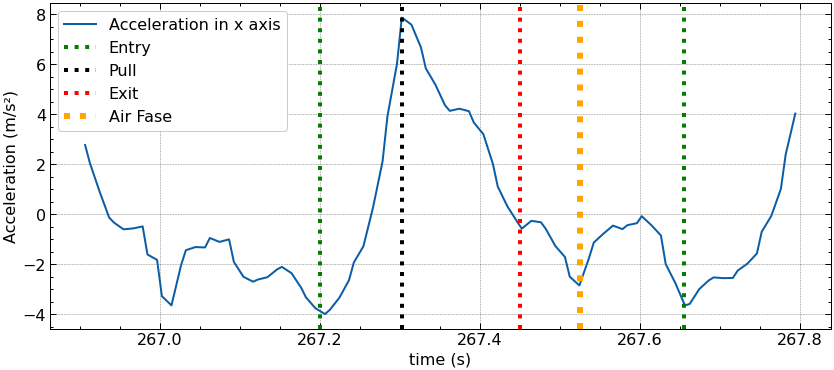

In [8]:
data = select_data_intervale(raw_data, 266.9, 267.8)
plt.figure(figsize=(14, 6))

plt.plot(data['time'], data.ax, label="Acceleration in x axis")
#plt.plot(data['time'], np.sqrt(data.ax**2+data.ay**2+data.az**2), label="Total Acceleration")
plt.axvline(x=267.2, color='green',ls=':', label='Entry', lw=4)
plt.axvline(x=267.302257, color='black',ls=':', label='Pull', lw=4)
plt.axvline(x=267.45, color='red',ls=':', label='Exit', lw=4)
plt.axvline(x=267.525, color='orange',ls=':', label='Air Fase', lw=6)
plt.axvline(x=267.655, color='green',ls=':', lw=4)
plt.xlabel('time (s)')
plt.legend(loc='upper left')

plt.ylabel(r'Acceleration (m/s²)')
plt.savefig("images/stroke.jpeg", dpi=150)

## Algoritmo para detectar strokes

In [9]:
def get_all_peaks_and_hollows(data):

    # ,threshold=0.04)
    peaks, _ = find_peaks(data.ax, distance=30, prominence=1)
    local_peaks = data.ax.iloc[peaks]
    data['max'] = local_peaks[local_peaks > 1]
    data['min'] = data.ax[(data.ax.shift(1) > data.ax) & (
        data.ax.shift(-1) > data.ax) & (data.ax < 0)]
    data_peaks = data[~(data['max'].isna())].copy()
    data_hollow = data[~(data['min'].isna())].copy()
    return data_peaks, data_hollow
def get_peaks_and_hollows(data):

    data_peaks, data_hollow = get_all_peaks_and_hollows(data)

    pk = data_peaks.copy()

    index_begin_stroke = list()
    loop_iteration = 0
    for index, row in data_peaks.iterrows():
        if loop_iteration == 0:
            time_peak = row.time
            crop = data_hollow[(data_hollow.time < time_peak)].copy()
            try:
                index_nearts_hollow = crop.time.index[-1]
                index_begin_stroke.append(index_nearts_hollow)
                last_Time = time_peak
            except IndexError:
                last_Time = time_peak
                continue
        else:
            time_peak = row.time
            crop = data_hollow[(data_hollow.time > last_Time) & (
                data_hollow.time < time_peak)].copy()

            #min_acc = crop.ax.argmin()
            #index_nearts_hollow = crop.Time.index[min_acc]
            try:
                index_nearts_hollow = crop.time.index[-1]
                index_begin_stroke.append(index_nearts_hollow)
                last_Time = time_peak
            except IndexError:
                last_Time = time_peak
                continue

        loop_iteration += 1
    hl = data.iloc[index_begin_stroke]
    hl = hl.reset_index(drop=True)
    pk = pk.reset_index(drop=True)
    return pk, hl

def get_exits(data, strokes):
    exits = data.copy()
    exits = exits.drop(index=exits.index)
    for stk in strokes:
        peak, index = get_peaks(stk)
        exitpoint = stk.iloc[[index]]
        exits = pd.concat([exits, exitpoint])
        exits = exits.sort_values(by='time', ascending=True)
        exits = exits.reset_index(drop=True)
    return exits

def get_stroke_list(data):

    stroke_list = list()

    peaks, hollows = get_peaks_and_hollows(data)
    #exits = get_exits(data, hollows)
    #data = pd.concat([data, exits])
    for index, row in hollows.iterrows():
        if index == 0:
            mask = (data.time >= row.time)
            crop = data[mask].reset_index(drop=True).copy()
            stroke_list.append(crop)
        else:
            mask = (data.time >=
                    hollows.iloc[index - 1].time) & (data.time <= row.time)
            crop = data[mask].reset_index(drop=True).copy()
            stroke_list.append(crop)
    stroke_list = stroke_list[1:]
    exits = get_exits(data, stroke_list)
    return stroke_list, exits
def get_peaks(data):
    # peaks = find_peaks_cwt(data.ax, data.Time)#, height=0)

    index_max_ax = data.ax.argmax()
    # print(index_max_ax)
    acc_ax = data.ax.iloc[index_max_ax:].copy()

    peaks = list()
    lowest_peak_value = 99999
    lowest_peak_index = 0
    for index, ax in zip(acc_ax.index, acc_ax):
        #print("Index: {} Acc: {}".format(index,ax))
        if index == index_max_ax:
            continue
        elif index == index_max_ax + len(acc_ax) - 1:
            continue
        else:
            if ax > acc_ax[index - 1] and ax > acc_ax[index + 1]:
                if abs(ax) < lowest_peak_value:
                    lowest_peak_value = ax
                    lowest_peak_index = index
    if lowest_peak_value == 99999:
        lowest_peak_index = acc_ax.abs().argmin() + index_max_ax
        #print("Lowest Index: ", lowest_peak_index)
        # rint(acc_ax)
        lowest_peak_value = acc_ax[lowest_peak_index]

        return lowest_peak_value, lowest_peak_index
    return lowest_peak_value, lowest_peak_index

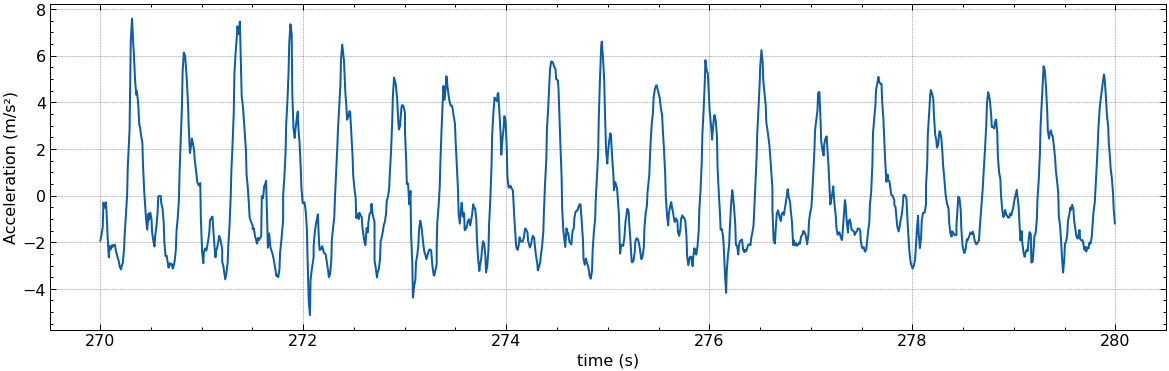

In [10]:
start_data = select_data_intervale(raw_data, start=270, end=280)
plt.figure(figsize=(20, 6))
plt.plot(start_data['time'], start_data.ax, label="XX Acceleration")
plt.xlabel('time (s)')
plt.ylabel(r'Acceleration (m/s²)')
plt.show()

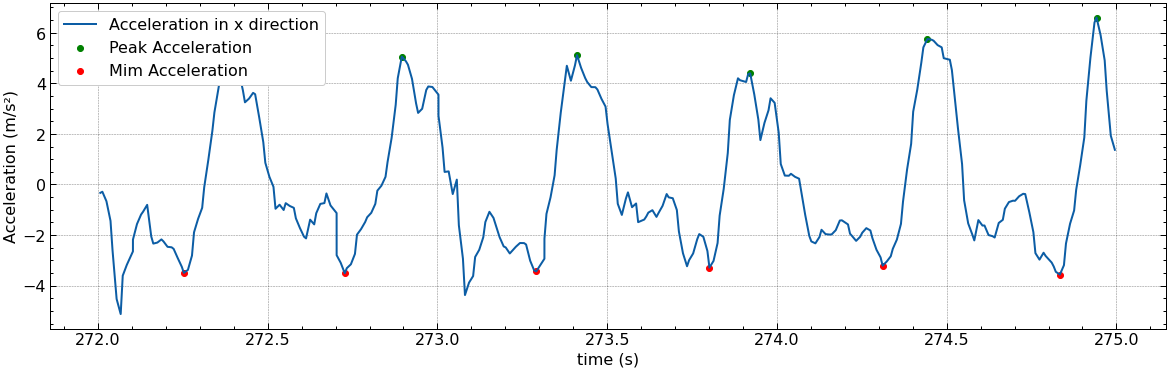

In [11]:
start_data = select_data_intervale(raw_data, start=272, end=275)
data_peaks, data_hollow = get_peaks_and_hollows(start_data)
stroke_list, exits = get_stroke_list(data)
plt.figure(figsize=(20, 6))
plt.plot(start_data['time'], start_data.ax, label=r'Acceleration in x direction')
plt.scatter(data_peaks.time, data_peaks.ax, label='Peak Acceleration', color='green')
plt.scatter(data_hollow.time, data_hollow.ax, label='Mim Acceleration', color='red')
#plt.scatter(exits.time, exits.ax, label='Exit', color='orange')
plt.xlabel('time (s)')
plt.ylabel(r'Acceleration (m/s²)')
plt.legend()
plt.show()

A melhor forma para detectar para stroke é encontrar primeiro o seu maximo - peak. Para isso irei usar a funcao [find_peaks](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html) do modulo scipy. 

This function takes a 1-D array and finds all local maxima by simple comparison of neighboring values. Optionally, a subset of these peaks can be selected by specifying conditions for a peak’s properties.

Uma fez que é humanamente impossivel que um stroke veja mais curto que 0.3 segundos, podemos indicar o parametro distance como 30 - Uma vez que a sample frequency is of 100 Hz, 0.3 segundos correspondem a 30 pontos.


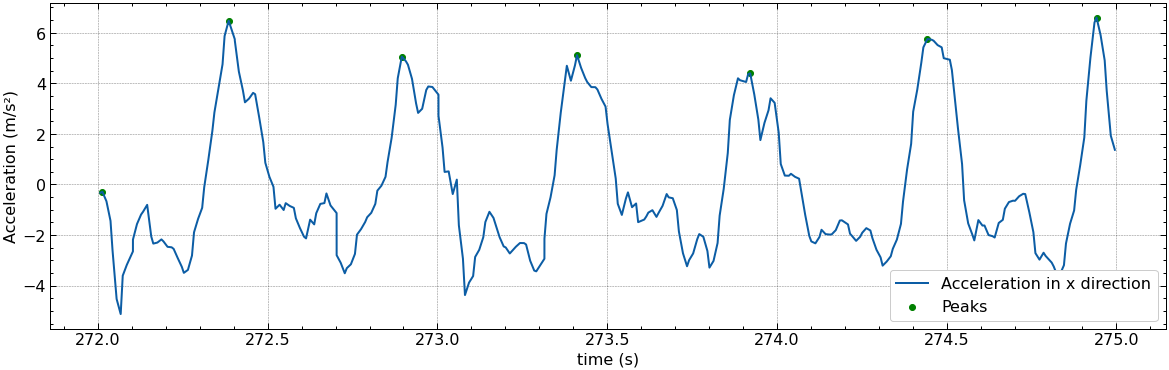

In [12]:
peaks, _ = find_peaks(start_data.ax, distance=30)
plt.figure(figsize=(20, 6))
plt.scatter(start_data['time'].iloc[peaks], start_data.ax.iloc[peaks], label=r'Peaks', color='green')
plt.plot(start_data['time'], start_data.ax, label=r'Acceleration in x direction')
plt.xlabel('time (s)')
plt.ylabel(r'Acceleration (m/s²)')
plt.legend()
plt.show()

Uma vez encontrados os PEAKS, para detectar o entry point temos de descobrir o ponto de inflexao do sinal imediatamente antes do PEAK.

Para isso vou encontrar todos os minimos relativos com aceleração negativa e posteriormente escolher o que tiver menor distancia ao PEAK 



In [13]:
local_minimum_index = start_data.ax[(start_data.ax.shift(1) > start_data.ax) & (
    start_data.ax.shift(-1) > start_data.ax) & (start_data.ax < 0)].index
local_minimum_index
local_minimum = start_data.iloc[local_minimum_index]

In [14]:
def distance_to_peak_point(peaks, local_minimum ):
    entry_point_index = list()
    for index, row in peaks.iterrows():
        mask = (local_minimum.time < row.time)
        aux_df = local_minimum[mask]
        aux_df.sort_values(by='time')
        try:
            point_index = aux_df.tail(1).index.values[0]
        except IndexError:
            point_index = index

        entry_point_index.append(point_index)
    return entry_point_index

In [15]:
entry_point_index = distance_to_peak_point(start_data.iloc[peaks], local_minimum )
entry_point_index

[1, 25, 72, 129, 180, 231, 283]

In [16]:
local_peaks = start_data.ax.iloc[peaks]
start_data['max'] = local_peaks[local_peaks > 1]
start_data['min'] = start_data.ax[(start_data.ax.shift(1) > start_data.ax) & (
    start_data.ax.shift(-1) > start_data.ax) & (start_data.ax < 0)]

data_peaks = start_data[~(start_data['max'].isna())].copy()
data_hollow = start_data[~(start_data['min'].isna())].copy()


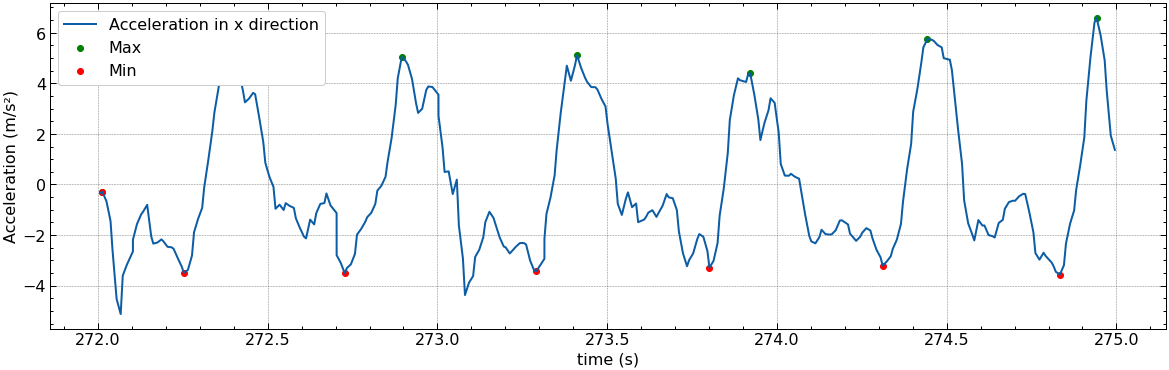

In [17]:
plt.figure(figsize=(20, 6))
plt.scatter(start_data.iloc[peaks]['time'], start_data.iloc[peaks]['ax'], label=r'Max', color='green')
plt.scatter(start_data['time'].iloc[entry_point_index], start_data['ax'].iloc[entry_point_index], label=r'Min', color="red")
plt.plot(start_data['time'], start_data.ax, label=r'Acceleration in x direction')
plt.xlabel('time (s)')
plt.ylabel(r'Acceleration (m/s²)')
plt.legend()
plt.show()

Agora que temos o ponto inicial da remada podemos dividir a serie nas suas vairas remadas e apartir dai, separa-los nas suas varias fazes


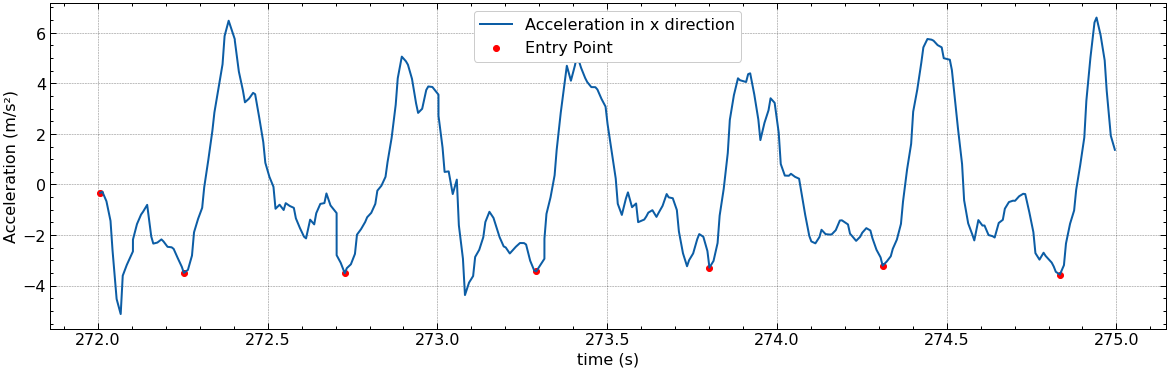

In [18]:
start_data = select_data_intervale(raw_data, start=272, end=275)
entries = get_entry_points(start_data)
plt.figure(figsize=(20, 6))
plt.scatter(entries.time, entries.ax, label=r'Entry Point', color='red')
plt.plot(start_data['time'], start_data.ax, label=r'Acceleration in x direction')
plt.xlabel('time (s)')
plt.ylabel(r'Acceleration (m/s²)')
plt.legend()
plt.show()

In [19]:
stroke_list = list()
for index, row in entries.iterrows():
    print(f"Index: {index}")
    if index == 0:    
        mask = (start_data.time < row.time)
        aux_df = start_data[mask].copy()
        stroke_list.append(aux_df)
    else:
        mask = (start_data.time >=
                    entries.iloc[index - 1].time) & (start_data.time <= row.time)
        aux_df = start_data[mask].reset_index(drop=True).copy()
        stroke_list.append(aux_df)
stroke_list

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6


[Empty DataFrame
 Columns: [gx, gy, gz, ax, ay, az, roll, pitch, yaw, time_stamp, VideoRecord, DataRecord, time]
 Index: [],
           gx        gy        gz        ax        ay        az      roll  \
 0  -0.303210 -0.713594  9.749387 -0.333269 -3.177444  3.020808 -4.186224   
 1  -0.298374 -0.669596  9.752654 -0.288003 -0.709127  3.357209 -3.927639   
 2  -0.293498 -0.622371  9.755930 -0.663303  0.274086  3.978136 -3.650187   
 3  -0.289509 -0.569115  9.759300 -1.440073  1.832792  3.568042 -3.337431   
 4  -0.287110 -0.502820  9.763011 -2.612129  2.761037  3.370504 -2.948275   
 5  -0.287285 -0.413976  9.767178 -4.528494  1.874104  3.973194 -2.426997   
 6  -0.291172 -0.311500  9.770864 -5.124857  0.348749  4.333838 -1.825999   
 7  -0.299615 -0.197714  9.773578 -3.607091  0.552741  3.384060 -1.158903   
 8  -0.308457 -0.078836  9.774984 -3.179880  0.550264  2.387691 -0.462084   
 9  -0.317593  0.048067  9.774890 -2.647738  0.369807  2.112439  0.281741   
 10 -0.329296  0.184315  9.7

In [20]:
entries

,gx,gy,gz,ax,ay,az,roll,pitch,yaw,time_stamp,VideoRecord,DataRecord,time
0,-0.303210,-0.713594,9.749387,-0.333269,-3.177444,3.020808,-4.186224,1.776600,-130.182067,2021-04-14 09:40:55.805850907,0,0,272.007047
1,-0.482893,1.061706,9.710370,-3.495531,-1.201627,-2.024703,6.239782,2.830115,-130.612574,2021-04-14 09:40:56.051844015,0,0,272.253040
2,-0.437560,-0.883272,9.730365,-3.511562,1.911522,-2.325258,-5.186796,2.564240,-129.323075,2021-04-14 09:40:56.525837904,0,0,272.727034
3,-0.515327,1.358183,9.671682,-3.435382,-0.956462,-1.635623,7.993709,3.020373,-130.422817,2021-04-14 09:40:57.089916072,0,0,273.291113
4,-0.470139,-1.222383,9.692080,-3.287949,0.220474,-2.574191,-7.188295,2.755309,-128.693209,2021-04-14 09:40:57.599992465,0,0,273.801189
5,-0.502662,1.632721,9.629807,-3.210485,-1.456469,-2.156721,9.622912,2.946079,-129.781012,2021-04-14 09:40:58.110100303,0,0,274.311297
6,-0.482632,-0.655225,9.746250,-3.565384,0.436184,-1.489802,-3.846119,2.828581,-128.748356,2021-04-14 09:40:58.632144747,0,0,274.833341


In [21]:
mk = (start_data.time >= entries.iloc[0].time) & (start_data.time <= entries.iloc[1].time)
start_data[mk]

,gx,gy,gz,ax,ay,az,roll,pitch,yaw,time_stamp,VideoRecord,DataRecord,time
0,-0.303210,-0.713594,9.749387,-0.333269,-3.177444,3.020808,-4.186224,1.776600,-130.182067,2021-04-14 09:40:55.805850907,0,0,272.007047
1,-0.298374,-0.669596,9.752654,-0.288003,-0.709127,3.357209,-3.927639,1.748254,-130.258292,2021-04-14 09:40:55.811854479,0,0,272.013051
2,-0.293498,-0.622371,9.755930,-0.663303,0.274086,3.978136,-3.650187,1.719680,-130.340131,2021-04-14 09:40:55.823844475,0,0,272.025041
3,-0.289509,-0.569115,9.759300,-1.440073,1.832792,3.568042,-3.337431,1.696295,-130.431369,2021-04-14 09:40:55.835850044,0,0,272.037047
4,-0.287110,-0.502820,9.763011,-2.612129,2.761037,3.370504,-2.948275,1.682235,-130.549285,2021-04-14 09:40:55.841849893,0,0,272.043046
5,-0.287285,-0.413976,9.767178,-4.528494,1.874104,3.973194,-2.426997,1.683261,-130.668909,2021-04-14 09:40:55.853853741,0,0,272.055050
6,-0.291172,-0.311500,9.770864,-5.124857,0.348749,4.333838,-1.825999,1.706043,-130.748918,2021-04-14 09:40:55.865834403,0,0,272.067031
7,-0.299615,-0.197714,9.773578,-3.607091,0.552741,3.384060,-1.158903,1.755528,-130.797180,2021-04-14 09:40:55.871862419,0,0,272.073059
8,-0.308457,-0.078836,9.774984,-3.179880,0.550264,2.387691,-0.462084,1.807351,-130.836536,2021-04-14 09:40:55.883854358,0,0,272.085051
9,-0.317593,0.048067,9.774890,-2.647738,0.369807,2.112439,0.281741,1.860904,-130.867408,2021-04-14 09:40:55.901866074,0,0,272.103063


In [22]:
entries.iloc[0].time

272.00704737300055

In [23]:
entries.iloc[1].time

272.25304048100054

In [24]:
start_data.head(20)

,gx,gy,gz,ax,ay,az,roll,pitch,yaw,time_stamp,VideoRecord,DataRecord,time
0,-0.303210,-0.713594,9.749387,-0.333269,-3.177444,3.020808,-4.186224,1.776600,-130.182067,2021-04-14 09:40:55.805850907,0,0,272.007047
1,-0.298374,-0.669596,9.752654,-0.288003,-0.709127,3.357209,-3.927639,1.748254,-130.258292,2021-04-14 09:40:55.811854479,0,0,272.013051
2,-0.293498,-0.622371,9.755930,-0.663303,0.274086,3.978136,-3.650187,1.719680,-130.340131,2021-04-14 09:40:55.823844475,0,0,272.025041
3,-0.289509,-0.569115,9.759300,-1.440073,1.832792,3.568042,-3.337431,1.696295,-130.431369,2021-04-14 09:40:55.835850044,0,0,272.037047
4,-0.287110,-0.502820,9.763011,-2.612129,2.761037,3.370504,-2.948275,1.682235,-130.549285,2021-04-14 09:40:55.841849893,0,0,272.043046
5,-0.287285,-0.413976,9.767178,-4.528494,1.874104,3.973194,-2.426997,1.683261,-130.668909,2021-04-14 09:40:55.853853741,0,0,272.055050
6,-0.291172,-0.311500,9.770864,-5.124857,0.348749,4.333838,-1.825999,1.706043,-130.748918,2021-04-14 09:40:55.865834403,0,0,272.067031
7,-0.299615,-0.197714,9.773578,-3.607091,0.552741,3.384060,-1.158903,1.755528,-130.797180,2021-04-14 09:40:55.871862419,0,0,272.073059
8,-0.308457,-0.078836,9.774984,-3.179880,0.550264,2.387691,-0.462084,1.807351,-130.836536,2021-04-14 09:40:55.883854358,0,0,272.085051
9,-0.317593,0.048067,9.774890,-2.647738,0.369807,2.112439,0.281741,1.860904,-130.867408,2021-04-14 09:40:55.901866074,0,0,272.103063


In [25]:
strokes = get_strokes(start_data)

In [26]:
stroke = strokes[0]

In [27]:
dd = stroke.iloc[(stroke['ax']-0).abs().argsort()[:2]].index.to_list()[-1]
dd

0

<AxesSubplot:>

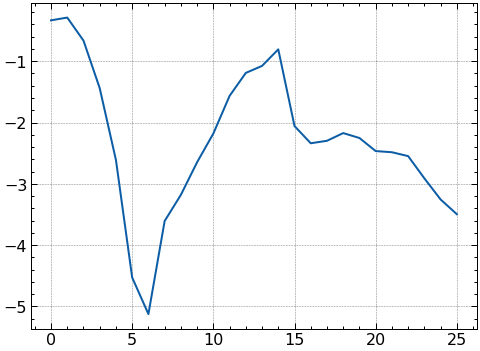

In [28]:
stroke.ax.plot()

AttributeError: 'tuple' object has no attribute 'time'

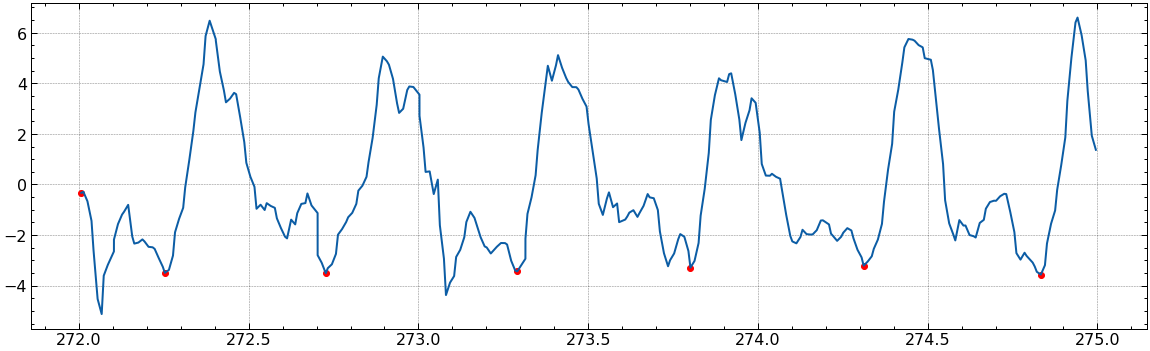

In [29]:
start_data = select_data_intervale(raw_data, start=272, end=275)
entries = get_entry_points(start_data)
peaks = get_peaks(start_data)
exits, air_fase = get_exit_and_air_points(start_data)
strokes = get_strokes(start_data)
plt.figure(figsize=(20, 6))

plt.plot(start_data['time'], start_data.ax, label=r'Acceleration in x direction')
plt.scatter(entries.time, entries.ax, label=r'Entry Point', color='red')
plt.scatter(peaks.time, peaks.ax, label=r'Peaks Point', color='green')
plt.scatter(exits.time, exits.ax, label=r'Exits Point', color='black')
plt.scatter(air_fase.time, air_fase.ax, label=r'Air Point', color='yellow')

plt.xlabel('time (s)')
plt.ylabel(r'Acceleration (m/s²)')
plt.legend()
plt.show()

In [ ]:
indicators = strokes_indicators(data)
indicators

,Speed Variation - Entry Fase,Pitch Amplitude - Entry Fase,Mean Acceleration - Entry Fase,Mean Pitch - Entry Fase,Speed Variation - Pull Fase,Pitch Amplitude - Pull Fase,Mean Acceleration - Pull Fase,Mean Pitch - Pull Fase,Speed Variation - Exit Fase,Pitch Amplitude - Exit Fase,...,Mean Acceleration - Air Fase,Mean Pitch - Air Fase,Speed Variation - Water Fase,Pitch Amplitude - Water Fase,Mean Acceleration - Water Fase,Mean Pitch - Water Fase,Water Time,Air Time,Stroke Rate,Stroke Time
0,-0.013440,0.061396,-0.557079,2.055511,-0.006380,0.035598,-1.053039,2.008556,-0.077583,0.076447,...,-2.291114,2.382052,-0.430241,0.951552,-2.291114,2.382052,0.060009,0.192031,238.057911,0.252040
1,-0.008069,0.116904,0.283569,2.946511,0.577618,0.886667,3.991412,2.522623,-0.002622,0.056844,...,-1.530127,2.155314,-0.384145,0.913777,-1.530127,2.155314,0.246038,0.252033,120.464652,0.498071
2,0.041714,0.130797,0.598506,2.824806,0.406868,0.840880,2.636374,2.407790,-0.101849,0.123946,...,-1.985984,2.301382,-0.366018,0.949108,-1.985984,2.301382,0.300044,0.192098,121.915970,0.492142


In [ ]:
def _color_red_or_green(val):
    if val > 0.7:
        color = 'red'
    elif val < -0.7:
        color = 'red'
    
    else:
        color = 'white'

    return 'color: %s' % color

In [ ]:
indicators.corr().style.applymap(_color_red_or_green)

,Speed Variation - Entry Fase,Pitch Amplitude - Entry Fase,Mean Acceleration - Entry Fase,Mean Pitch - Entry Fase,Speed Variation - Pull Fase,Pitch Amplitude - Pull Fase,Mean Acceleration - Pull Fase,Mean Pitch - Pull Fase,Speed Variation - Exit Fase,Pitch Amplitude - Exit Fase,Mean Acceleration - Exit Fase,Mean Pitch - Exit Fase,Speed Variation - Air Fase,Pitch Amplitude - Air Fase,Mean Acceleration - Air Fase,Mean Pitch - Air Fase,Speed Variation - Water Fase,Pitch Amplitude - Water Fase,Mean Acceleration - Water Fase,Mean Pitch - Water Fase,Water Time,Air Time,Stroke Rate,Stroke Time
Speed Variation - Entry Fase,1.000000,0.718985,0.769952,0.466856,0.318095,0.534721,0.342427,0.387198,-0.622507,0.929974,-0.384953,-0.698818,0.776630,0.368443,-0.025436,0.076514,0.776630,0.368443,-0.025436,0.076514,0.736674,-0.420686,-0.565687,0.557107
Pitch Amplitude - Entry Fase,0.718985,1.000000,0.997081,0.950297,0.887631,0.971773,0.899208,0.919201,0.096364,0.413127,0.364689,-0.005287,0.996222,-0.381227,0.676513,-0.637976,0.996222,-0.381227,0.676513,-0.637976,0.999667,0.328065,-0.979853,0.977729
Mean Acceleration - Entry Fase,0.769952,0.997081,1.000000,0.923751,0.849876,0.950924,0.863177,0.886451,0.020086,0.481452,0.292531,-0.081623,0.999945,-0.309528,0.618311,-0.577319,0.999945,-0.309528,0.618311,-0.577319,0.998719,0.254981,-0.961743,0.958851
Mean Pitch - Entry Fase,0.466856,0.950297,0.923751,1.000000,0.986905,0.996925,0.990735,0.996118,0.401470,0.109059,0.636465,0.306316,0.919666,-0.650111,0.872172,-0.846020,0.919666,-0.650111,0.872172,-0.846020,0.941949,0.605873,-0.993333,0.994475
Speed Variation - Pull Fase,0.318095,0.887631,0.849876,0.986905,1.000000,0.971229,0.999668,0.997273,0.543947,-0.052711,0.752546,0.455855,0.844279,-0.764163,0.939661,-0.920941,0.844279,-0.764163,0.939661,-0.920941,0.875455,0.726267,-0.961731,0.964520
Pitch Amplitude - Pull Fase,0.534721,0.971773,0.950924,0.996925,0.971229,1.000000,0.977045,0.986156,0.328463,0.186621,0.574065,0.230776,0.947612,-0.588567,0.831154,-0.801638,0.947612,-0.588567,0.831154,-0.801638,0.965364,0.541666,-0.999312,0.999643
Mean Acceleration - Pull Fase,0.342427,0.899208,0.863177,0.990735,0.999668,0.977045,1.000000,0.998844,0.522137,-0.026953,0.735321,0.432762,0.857812,-0.747283,0.930531,-0.910590,0.857812,-0.747283,0.930531,-0.910590,0.887622,0.708306,-0.968474,0.971004
Mean Pitch - Pull Fase,0.387198,0.919201,0.886451,0.996118,0.997273,0.986156,0.998844,1.000000,0.480534,0.021133,0.701891,0.388923,0.881528,-0.714474,0.911850,-0.889668,0.881528,-0.714474,0.911850,-0.889668,0.908737,0.673553,-0.979330,0.981374
Speed Variation - Exit Fase,-0.622507,0.096364,0.020086,0.401470,0.543947,0.328463,0.522137,0.480534,1.000000,-0.866625,0.961939,0.994823,0.009555,-0.956916,0.798195,-0.827950,0.009555,-0.956916,0.798195,-0.827950,0.070656,0.971872,-0.293215,0.303111
Pitch Amplitude - Exit Fase,0.929974,0.413127,0.481452,0.109059,-0.052711,0.186621,-0.026953,0.021133,-0.866625,1.000000,-0.697292,-0.912845,0.490656,0.684406,-0.391162,0.437705,0.490656,0.684406,-0.391162,0.437705,0.436481,-0.724740,-0.222922,0.212803


In [ ]:
indicators

,Speed Variation - Entry Fase,Pitch Amplitude - Entry Fase,Mean Acceleration - Entry Fase,Mean Pitch - Entry Fase,Speed Variation - Pull Fase,Pitch Amplitude - Pull Fase,Mean Acceleration - Pull Fase,Mean Pitch - Pull Fase,Speed Variation - Exit Fase,Pitch Amplitude - Exit Fase,...,Mean Acceleration - Air Fase,Mean Pitch - Air Fase,Speed Variation - Water Fase,Pitch Amplitude - Water Fase,Mean Acceleration - Water Fase,Mean Pitch - Water Fase,Water Time,Air Time,Stroke Rate,Stroke Time
0,-0.013440,0.061396,-0.557079,2.055511,-0.006380,0.035598,-1.053039,2.008556,-0.077583,0.076447,...,-2.291114,2.382052,-0.430241,0.951552,-2.291114,2.382052,0.060009,0.192031,238.057911,0.252040
1,-0.008069,0.116904,0.283569,2.946511,0.577618,0.886667,3.991412,2.522623,-0.002622,0.056844,...,-1.530127,2.155314,-0.384145,0.913777,-1.530127,2.155314,0.246038,0.252033,120.464652,0.498071
2,0.041714,0.130797,0.598506,2.824806,0.406868,0.840880,2.636374,2.407790,-0.101849,0.123946,...,-1.985984,2.301382,-0.366018,0.949108,-1.985984,2.301382,0.300044,0.192098,121.915970,0.492142


In [ ]:
indicators = list()
i = 0
for stroke, (_, peak), (_, exit), (_, air) in zip(strokes, peaks.iterrows(), exits.iterrows(), air_fase.iterrows()):
    print(f"Index: {i}")
    i += 1
    indicators_dict = dict()

    entry_fase_mask = (stroke.time <= peak.time) 
    entry_fase = stroke[entry_fase_mask].copy()
    print(f"Entry Time: {peak.time}")
    # indicators_dict['Speed Variation - Entry Fase'] = np.trapz(y=entry_fase.ax, x=entry_fase.time) 
    # indicators_dict['Pitch Amplitude - Entry Fase'] = entry_fase.pitch.max() - entry_fase.pitch.min() 
    # indicators_dict['Mean Acceleration - Entry Fase'] = entry_fase.ax.mean()
    # indicators_dict['Mean Pitch - Entry Fase'] = entry_fase.pitch.mean()
    
    indicators_calculator(entry_fase, "Entry Fase", indicators_dict)
    
    pull_fase_mask = (stroke.time >= peak.time) & (stroke.time <= exit.time)
    pull_fase = stroke[pull_fase_mask].copy()
    print(f"Pull Time: {exit.time}")
    # indicators_dict['Speed Variation - Pull Fase'] = np.trapz(y=pull_fase.ax, x=pull_fase.time) 
    # indicators_dict['Pitch Amplitude - Pull Fase'] = pull_fase.pitch.max() - pull_fase.pitch.min() 
    # indicators_dict['Mean Acceleration - Pull Fase'] = pull_fase.ax.mean()
    # indicators_dict['Mean Pitch - Pull Fase'] = pull_fase.pitch.mean()
    indicators_calculator(pull_fase, "Pull Fase", indicators_dict)


    exit_fase_mask =  (stroke.time >= exit.time) & (stroke.time <= air.time)
    exit_fase = stroke[exit_fase_mask].copy()
    print(f"Air Time: {air.time}")
    # indicators_dict['Speed Variation - Exit Fase'] = np.trapz(y=exit_fase.ax, x=exit_fase.time) 
    # indicators_dict['Pitch Amplitude - Exit Fase'] = exit_fase.pitch.max() - exit_fase.pitch.min() 
    # indicators_dict['Mean Acceleration - Exit Fase'] = exit_fase.ax.mean()
    # indicators_dict['Mean Pitch - Exit Fase'] = exit_fase.pitch.mean()
    
    indicators_calculator(exit_fase, "Exit Fase", indicators_dict)


    air_fase_mask = (stroke.time >= air.time) 
    air_fase = stroke[air_fase_mask].copy()

    # indicators_dict['Speed Variation - Air Fase'] = np.trapz(y=air_fase.ax, x=air_fase.time) 
    # indicators_dict['Pitch Amplitude - Air Fase'] = air_fase.pitch.max() - air_fase.pitch.min() 
    # indicators_dict['Mean Acceleration - Air Fase'] = air_fase.ax.mean()
    # indicators_dict['Mean Pitch - Air Fase'] = air_fase.pitch.mean()
    
    indicators_calculator(air_fase, "Air Fase", indicators_dict)
    
    indicators_dict['Water Time'] = air.time - stroke.head(1).time.values[0] 
    indicators_dict['Air Time'] =   stroke.tail(1).time.values[0] - air.time
    indicators_dict['Stroke Rate'] = 60.0 / (stroke.tail(1).time.values[0] -  stroke.head(1).time.values[0])
    indicators_dict['Stroke Time'] = (stroke.tail(1).time.values[0] -  stroke.head(1).time.values[0])
    indicators.append(indicators_dict)


indi = pd.DataFrame(indicators)
indi
    




Index: 0
Entry Time: 272.01305094500054
Pull Time: 272.02504094100055
Air Time: 272.0670308690005
Index: 1
Entry Time: 272.38504093000057
Pull Time: 272.5170375260006
Air Time: 272.5230426540006
Index: 2
Entry Time: 272.89505680500065
Pull Time: 273.0630832940007
Air Time: 273.08108382400076
Index: 3
Entry Time: 273.4111317510008
Pull Time: 273.53114900000077
Air Time: 273.5431511810008
Index: 4
Entry Time: 273.9212055880009
Pull Time: 274.07122649300084
Air Time: 274.1132334200009
Index: 5
Entry Time: 274.44327966200086
Pull Time: 274.55130861900096
Air Time: 274.58129796000094


,Speed Variation - Entry Fase,Pitch Amplitude - Entry Fase,Mean Acceleration - Entry Fase,Mean Pitch - Entry Fase,Speed Variation - Pull Fase,Pitch Amplitude - Pull Fase,Mean Acceleration - Pull Fase,Mean Pitch - Pull Fase,Speed Variation - Exit Fase,Pitch Amplitude - Exit Fase,Mean Acceleration - Exit Fase,Mean Pitch - Exit Fase,Speed Variation - Air Fase,Pitch Amplitude - Air Fase,Mean Acceleration - Air Fase,Mean Pitch - Air Fase,Water Time,Air Time,Stroke Rate,Stroke Time
0,-0.001865,0.028346,-0.310636,1.762427,-0.005703,0.028575,-0.475653,1.733967,-0.125467,0.037445,-2.873771,1.697503,-0.438019,1.124072,-2.482906,2.310172,0.059983,0.186010,243.909272,0.245993
1,0.106785,0.317236,0.917717,2.794514,0.423440,0.749225,3.236091,2.150459,-0.003169,0.040722,-0.527684,1.797109,-0.277982,0.824888,-1.423275,2.036088,0.270002,0.203992,126.583910,0.473994
2,-0.061009,0.276693,-0.334068,2.752372,0.447838,0.811416,2.569597,2.205127,-0.049199,0.016020,-2.973295,1.848160,-0.528045,1.164270,-2.568731,2.466682,0.354049,0.210029,106.368237,0.564078
3,0.135690,0.241493,1.311291,3.003304,0.380182,0.751738,3.003553,2.441261,-0.011817,0.042242,-0.984547,2.052523,-0.386195,0.780083,-1.531626,2.300888,0.252039,0.258038,117.629439,0.510076
4,0.161650,0.201236,1.416434,2.732750,0.274692,0.757113,1.782679,2.153252,-0.068467,0.048876,-1.612985,1.823805,-0.394005,1.092704,-2.042370,2.431201,0.312044,0.198063,117.622188,0.510108
5,0.068425,0.310520,0.624455,2.886271,0.463790,0.671166,4.054319,2.307263,-0.046614,0.064776,-1.587753,1.955221,-0.450067,0.902249,-1.832545,2.360302,0.270001,0.252043,114.932743,0.522044


In [ ]:
indi.corr()

,Speed Variation - Entry Fase,Pitch Amplitude - Entry Fase,Mean Acceleration - Entry Fase,Mean Pitch - Entry Fase,Speed Variation - Pull Fase,Pitch Amplitude - Pull Fase,Mean Acceleration - Pull Fase,Mean Pitch - Pull Fase,Speed Variation - Exit Fase,Pitch Amplitude - Exit Fase,Mean Acceleration - Exit Fase,Mean Pitch - Exit Fase,Speed Variation - Air Fase,Pitch Amplitude - Air Fase,Mean Acceleration - Air Fase,Mean Pitch - Air Fase,Water Time,Air Time,Stroke Rate,Stroke Time
Speed Variation - Entry Fase,1.000000,0.208479,0.975784,0.450288,0.133526,0.342473,0.289899,0.413298,0.417616,0.633058,0.826700,0.377913,0.716596,-0.606147,0.773476,-0.308799,0.151964,0.281406,-0.316037,0.208937
Pitch Amplitude - Entry Fase,0.208479,1.000000,0.372028,0.899364,0.983453,0.883198,0.963258,0.798886,0.868636,0.144034,0.552905,0.560759,0.184074,-0.513084,0.550982,-0.196259,0.819907,0.538219,-0.899297,0.870997
Mean Acceleration - Entry Fase,0.975784,0.372028,1.000000,0.625829,0.318765,0.530043,0.442017,0.587959,0.559518,0.560525,0.843323,0.516545,0.645010,-0.632776,0.792074,-0.237781,0.344035,0.392774,-0.506051,0.409127
Mean Pitch - Entry Fase,0.450288,0.899364,0.625829,1.000000,0.921201,0.949482,0.915881,0.962402,0.876839,0.203217,0.617601,0.790552,0.172724,-0.567634,0.612198,-0.015303,0.846054,0.689290,-0.963827,0.933791
Speed Variation - Pull Fase,0.133526,0.983453,0.318765,0.921201,1.000000,0.902716,0.958936,0.854767,0.846096,0.072656,0.454113,0.644385,0.037687,-0.459019,0.464170,-0.056249,0.854025,0.608337,-0.928653,0.919721
Pitch Amplitude - Pull Fase,0.342473,0.883198,0.530043,0.949482,0.902716,1.000000,0.819395,0.854608,0.818450,-0.012207,0.488185,0.597781,0.116865,-0.344654,0.444422,0.053402,0.958224,0.448553,-0.987377,0.970740
Mean Acceleration - Pull Fase,0.289899,0.963258,0.442017,0.915881,0.958936,0.819395,1.000000,0.872856,0.851749,0.327771,0.600917,0.719614,0.165459,-0.634883,0.628259,-0.164499,0.720400,0.729586,-0.864314,0.832415
Mean Pitch - Pull Fase,0.413298,0.798886,0.587959,0.962402,0.854767,0.854608,0.872856,1.000000,0.821437,0.219882,0.552021,0.924793,0.061676,-0.607316,0.581743,0.073623,0.730857,0.838808,-0.887732,0.870291
Speed Variation - Exit Fase,0.417616,0.868636,0.559518,0.876839,0.846096,0.818450,0.851749,0.821437,1.000000,0.063160,0.773277,0.642608,0.473706,-0.765852,0.784364,-0.449071,0.643060,0.573532,-0.783469,0.722723
Pitch Amplitude - Exit Fase,0.633058,0.144034,0.560525,0.203217,0.072656,-0.012207,0.327771,0.219882,0.063160,1.000000,0.511159,0.312465,0.336796,-0.477175,0.525709,-0.142621,-0.120835,0.430118,-0.076137,0.004859
